In [1]:
import os
import json
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

def plot_sensitivity_auto_fluid(
    run_folder: str,
    fold: int,
    test_csv: str,
    sample_index: int,
    total_propellant_vals: list[float],
    include_ratio_features: bool = True,
    fluid_ratio_min: float = 0.4,
    fluid_ratio_max: float = 10.0,
    num_fluid_points: int = 10
):
    """
    For a saved run in `run_folder` (containing
    {run_id}_fold{fold}.pth, {run_id}_hyperparams.json, {run_id}_norms.json),
    this will:
      1. Pick row `sample_index` from `test_csv` as baseline.
      2. Ensure the sample's Total.Proppant.Volume is in total_propellant_vals.
      3. Optionally include or drop the two per‐GPI ratio features.
      4. For each propellant value, sweep Total.Fluid between
         [fluid_ratio_min*prop, ..., fluid_ratio_max*prop] (num_fluid_points).
      5. Insert the sample’s actual Total.Fluid into that list if needed.
      6. For each fluid type, predict **only output 1** across the sweep.
      7. Plot one subplot per propellant: Output 1 vs Total Fluid
         with one curve per fluid type, marking the actual sample point.
    """
    # ─── Column names ─────────────────────────────────────────────────────────
    gpi_col           = "GPI (gross perforated interval ft)"
    prop_per_gpi_col  = "Proppant.per.GPI..lb.ft."
    fluid_per_gpi_col = "Fluid.per.GPI..gal.ft."
    total_prop_col    = "Total.Proppant.Volume"
    total_fluid_col   = "Total.Fluid"
    fluid_type_col    = "Fluid.Type"
    # Only output1 name (we ignore output2)
    output1_col       = "BOE_Prodoction_2 year cum"

    # ─── Load hyperparams & norms ─────────────────────────────────────────────
    run_id     = os.path.basename(os.path.normpath(run_folder))
    with open(os.path.join(run_folder, f"{run_id}_hyperparams.json")) as f:
        hp = json.load(f)
    with open(os.path.join(run_folder, f"{run_id}_norms.json")) as f:
        norms = json.load(f)

    layer_dims, activations = hp["layer_dims"], hp["activations"]
    y_mean = np.array(norms["y_mean"], dtype=np.float32)
    y_std  = np.array(norms["y_std"],  dtype=np.float32)
    x_mean = norms["x_mean"]
    x_std  = norms["x_std"]

    # ─── Load test data & baseline sample ────────────────────────────────────
    df = pd.read_csv(test_csv)
    sample = df.iloc[sample_index]

    sample_propellant = float(sample[total_prop_col])
    sample_fluid     = float(sample[total_fluid_col])
    sample_type      = sample[fluid_type_col]
    # true output1 for that sample
    y1_true_sample   = float(sample[output1_col])

    # ensure sample_propellant is included
    props = sorted(set(total_propellant_vals + [sample_propellant]))

    # numeric feature names (may drop the two ratio cols)
    numeric_feats = list(x_mean.keys())
    if not include_ratio_features:
        numeric_feats = [c for c in numeric_feats
                         if c not in (prop_per_gpi_col, fluid_per_gpi_col)]

    # fluid types & dummy feature names
    fluid_types = sorted(df[fluid_type_col].unique())
    dummy_feats = [f"{fluid_type_col}_{ft}" for ft in fluid_types]

    # ─── Define & load model ─────────────────────────────────────────────────
    class MLPNet(nn.Module):
        def __init__(self, in_dim, hidden_dims, activations, out_dim):
            super().__init__()
            layers, dims = [], [in_dim] + hidden_dims
            for i, h in enumerate(hidden_dims):
                layers.append(nn.Linear(dims[i], dims[i+1]))
                act = activations[i].lower()
                if   act=='relu':     layers.append(nn.ReLU())
                elif act=='tanh':     layers.append(nn.Tanh())
                elif act=='sigmoid':  layers.append(nn.Sigmoid())
                elif act=='softplus': layers.append(nn.Softplus())
                else: raise ValueError(f"Unknown activation '{activations[i]}'")
            layers.append(nn.Linear(dims[-1], out_dim))
            self.net = nn.Sequential(*layers)
        def forward(self, x):
            return self.net(x)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = MLPNet(
        in_dim      = len(numeric_feats) + len(dummy_feats),
        hidden_dims = layer_dims,
        activations = activations,
        out_dim     = 2  # still two outputs internally
    ).to(device)
    model.load_state_dict(torch.load(
        os.path.join(run_folder, f"{run_id}_fold{fold}.pth"),
        map_location=device
    ))
    model.eval()

    # prepare baseline feature dict
    base_feats = {f: float(sample[f]) for f in numeric_feats}
    for d in dummy_feats:
        base_feats[d] = 0.0

    # ─── Sweep & plot ─────────────────────────────────────────────────────────
    for prop_val in props:
        # build fluid sweep for this propellant
        base_list = np.linspace(
            prop_val * fluid_ratio_min,
            prop_val * fluid_ratio_max,
            num_fluid_points
        ).tolist()
        if prop_val == sample_propellant:
            fluid_vals = sorted(set(base_list + [sample_fluid]))
        else:
            fluid_vals = base_list

        # collect output1 predictions: dict[fluid_type] -> list of floats
        preds1 = {ft: [] for ft in fluid_types}
        gpi = float(sample[gpi_col])

        for ft in fluid_types:
            # set one-hot
            for dft in dummy_feats:
                base_feats[dft] = 1.0 if dft == f"{fluid_type_col}_{ft}" else 0.0

            for fv in fluid_vals:
                # assign swept inputs
                base_feats[total_prop_col]  = prop_val
                base_feats[total_fluid_col] = fv
                # recompute ratio features if included
                if include_ratio_features:
                    base_feats[prop_per_gpi_col]  = prop_val  / gpi
                    base_feats[fluid_per_gpi_col] = fv / gpi

                # build normalized input vector
                x_vec = [
                    (base_feats[f] - x_mean[f]) / x_std[f]
                    for f in numeric_feats
                ] + [ base_feats[d] for d in dummy_feats ]

                X_in = torch.tensor([x_vec], dtype=torch.float32).to(device)
                with torch.no_grad():
                    y_pred_n = model(X_in).cpu().numpy().flatten()
                y_pred = y_pred_n * y_std + y_mean

                # store only output1
                preds1[ft].append(float(y_pred[0]))

        # plot one subplot
        fig, ax = plt.subplots(figsize=(8,5))
        color_map = {}
        for ft in fluid_types:
            line, = ax.plot(
                fluid_vals,
                preds1[ft],
                label=str(ft)
            )
            color_map[ft] = line.get_color()

        # mark actual sample
        if prop_val == sample_propellant:
            ax.scatter(
                sample_fluid,
                y1_true_sample,
                marker='X', s=100,
                color=color_map[sample_type],
                edgecolor='k',
                label=f"actual ({sample_type})"
            )

        ax.set_title(
            f"{output1_col} vs Total Fluid\n"
            f"(Propellant={prop_val:.0f})"
        )
        ax.set_xlabel("Total Fluid")
        ax.set_ylabel(output1_col)
        ax.legend()
        plt.tight_layout()
        plt.show()




In [2]:
fluid_ratio_max = 1
fluid_ratio_min = 1/1.4
num_fluid_points = 1000
total_propellant_vals = np.linspace(300_000, 20_300_000, num=11).tolist()
sample_index=1

# relu

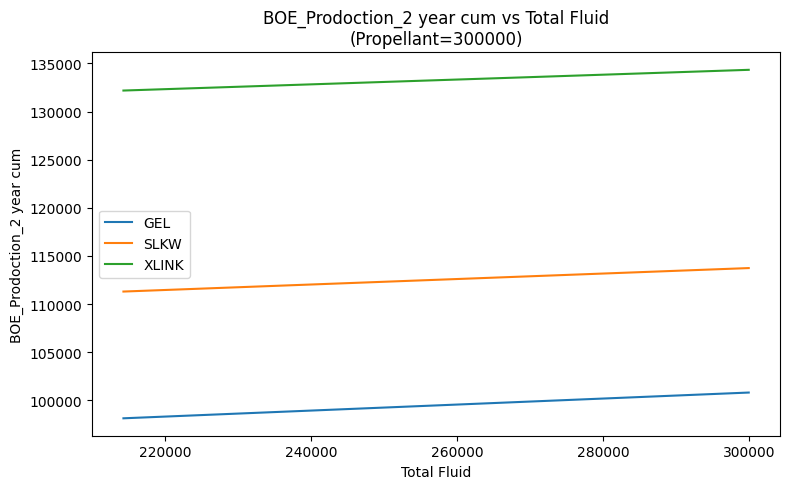

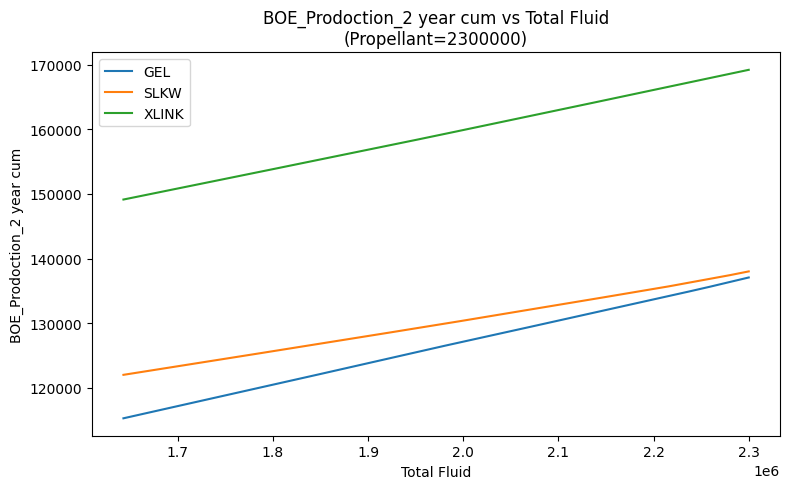

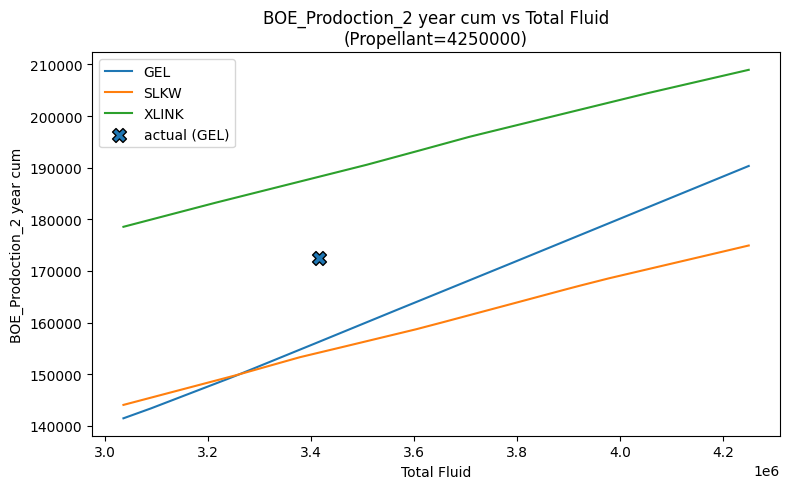

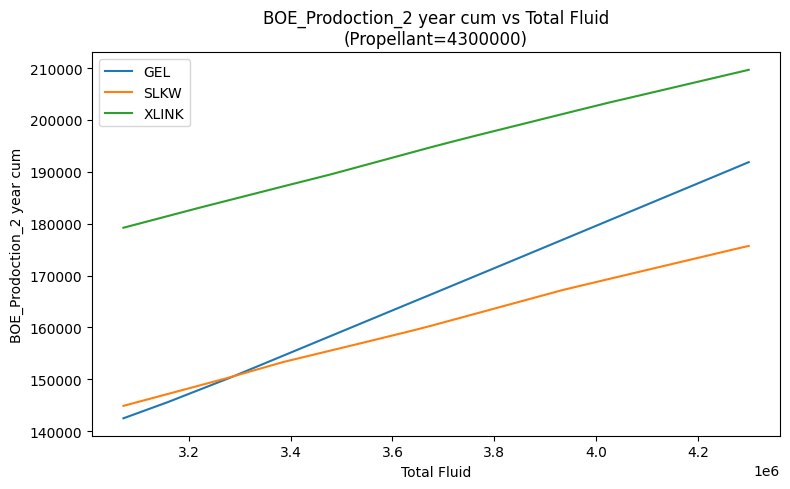

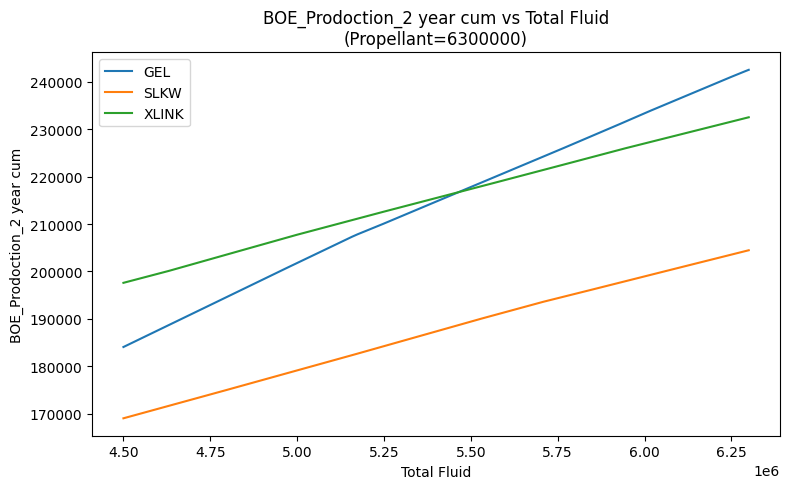

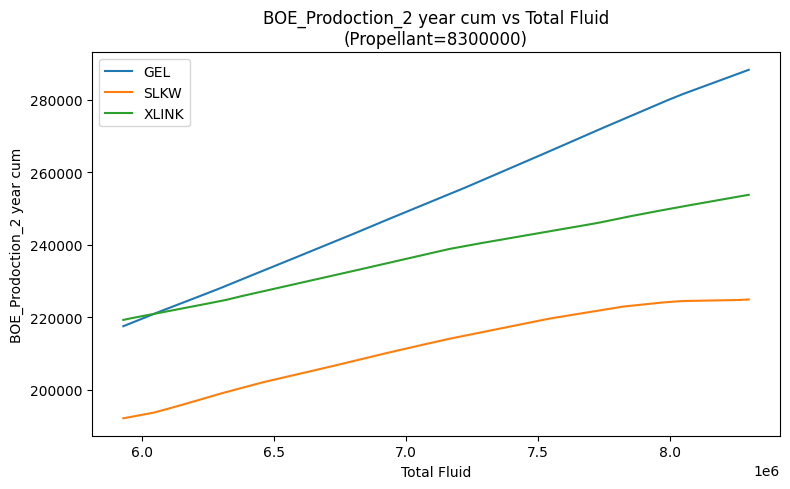

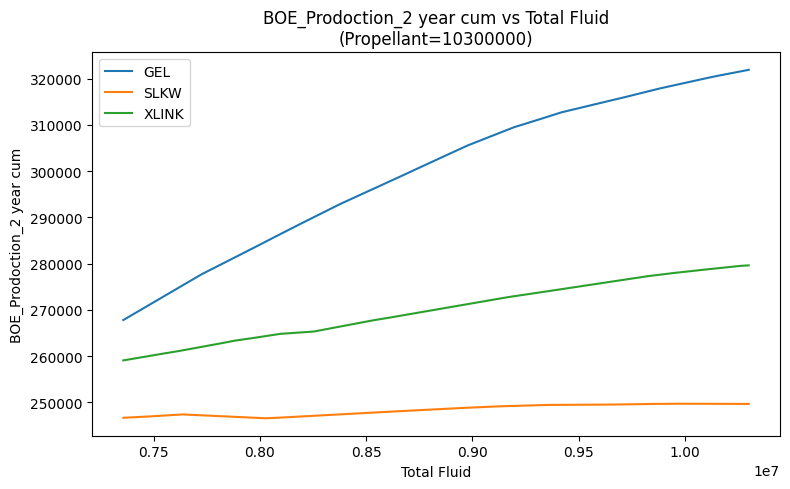

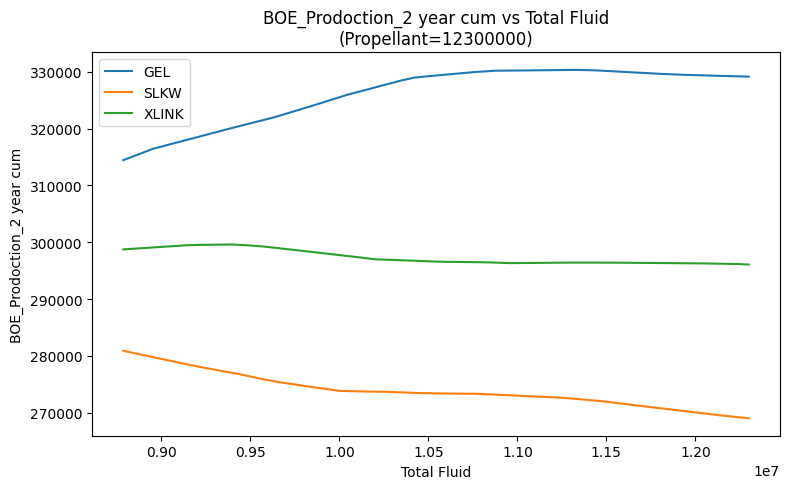

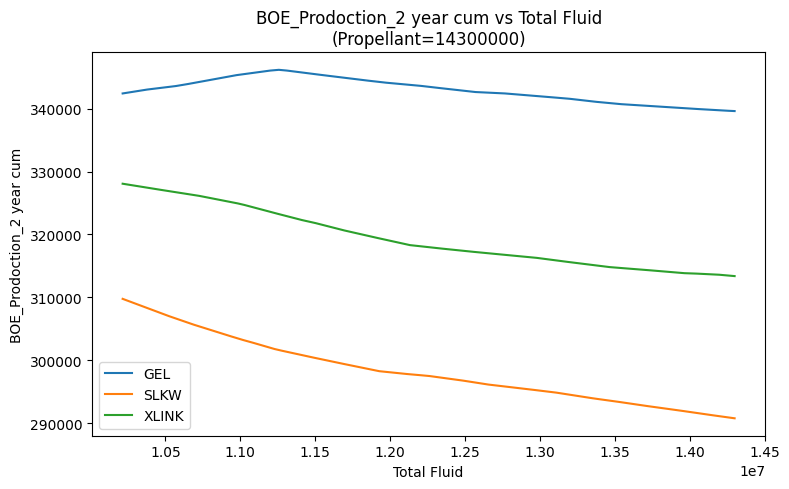

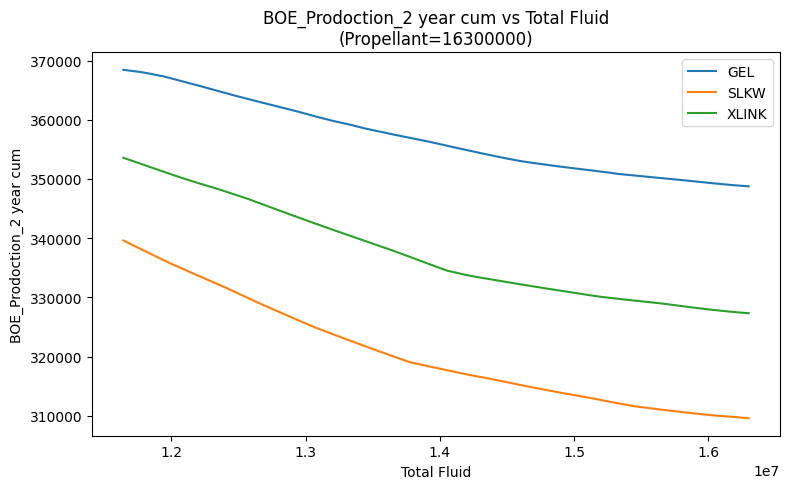

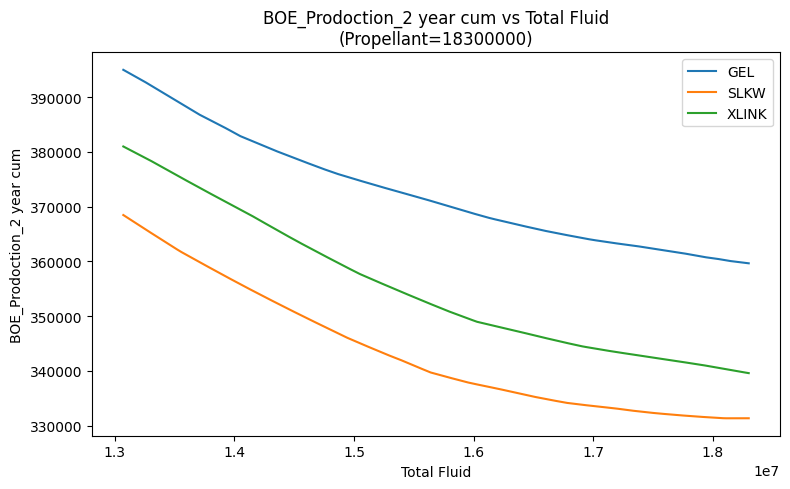

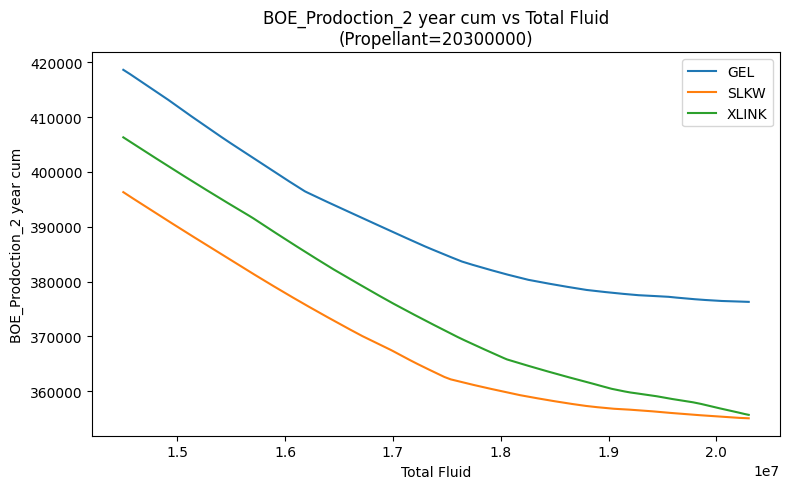

In [3]:
# ─── Full example call ──────────────────────────────────────────────────────
plot_sensitivity_auto_fluid(
    run_folder="/home/kamiar/chevron/Eagle-Ford/Second/d3feed88",
    fold=1,
    test_csv="/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_test.csv",
    include_ratio_features = True,
    sample_index=sample_index,
    total_propellant_vals = total_propellant_vals,
    fluid_ratio_min= fluid_ratio_min,
    fluid_ratio_max = fluid_ratio_max,
    num_fluid_points = num_fluid_points,
)


# softplus

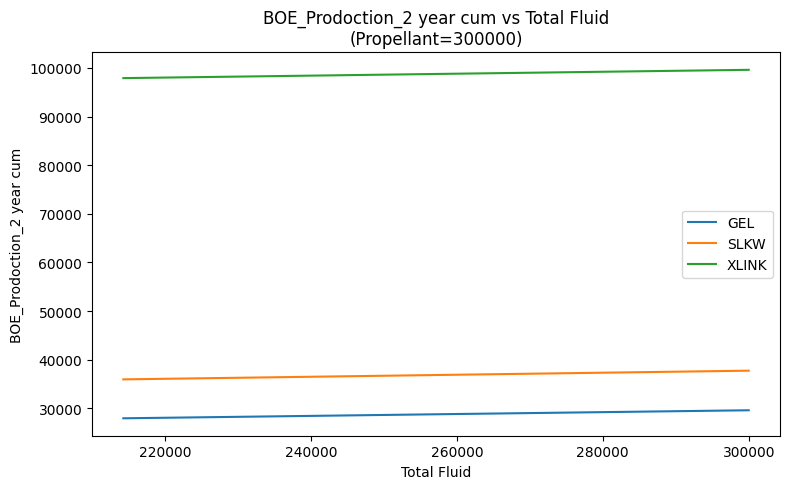

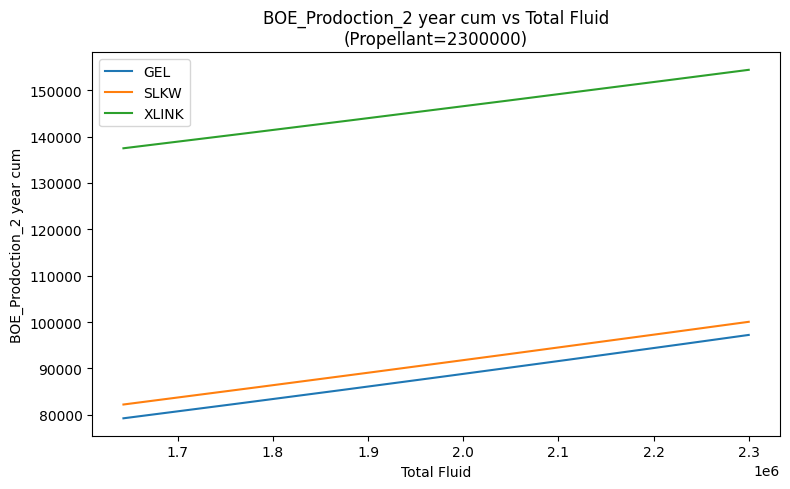

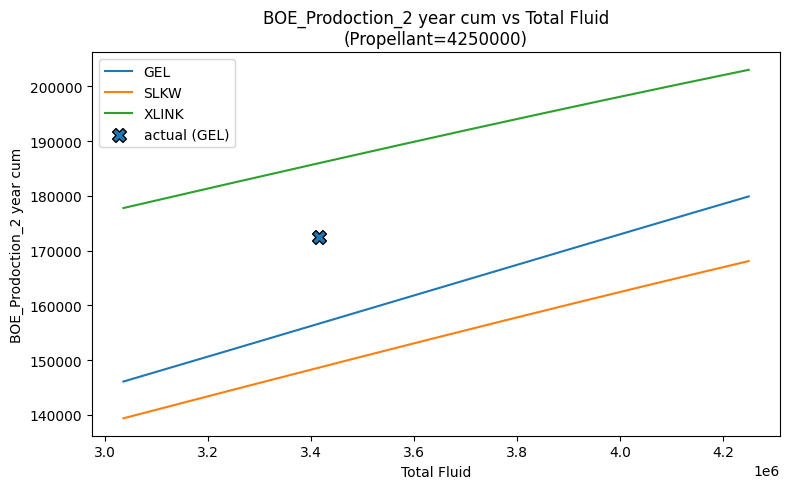

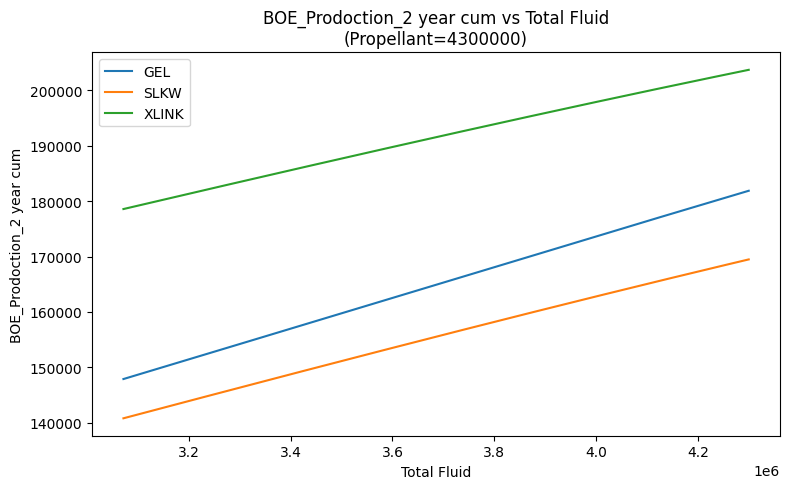

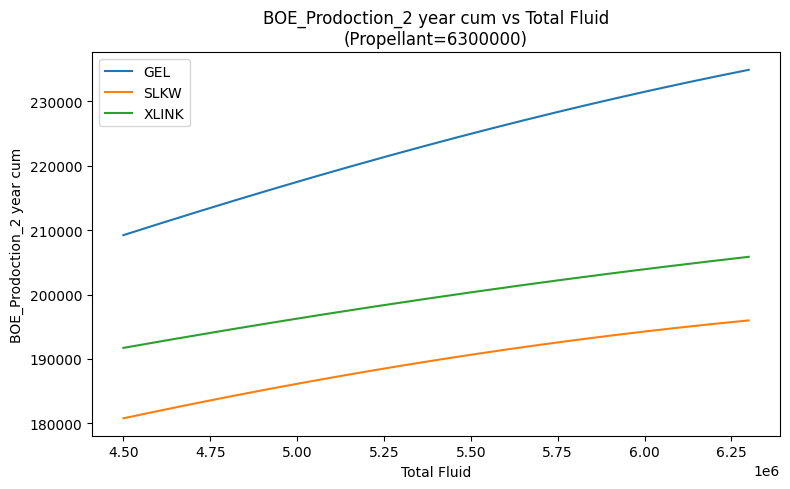

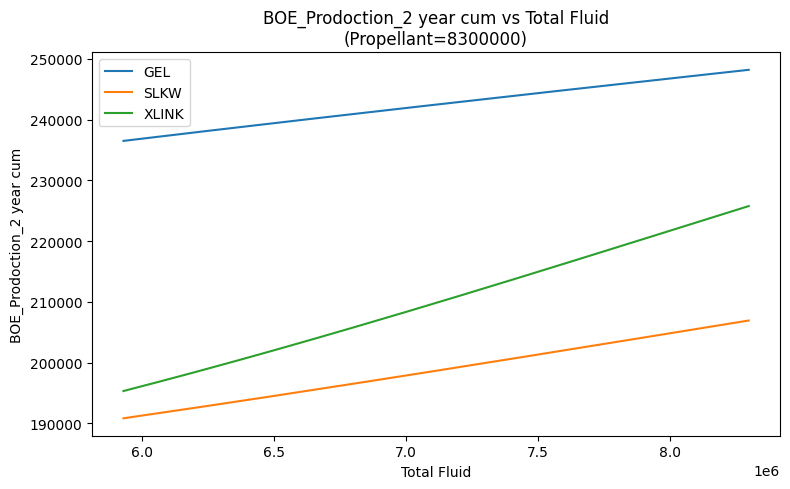

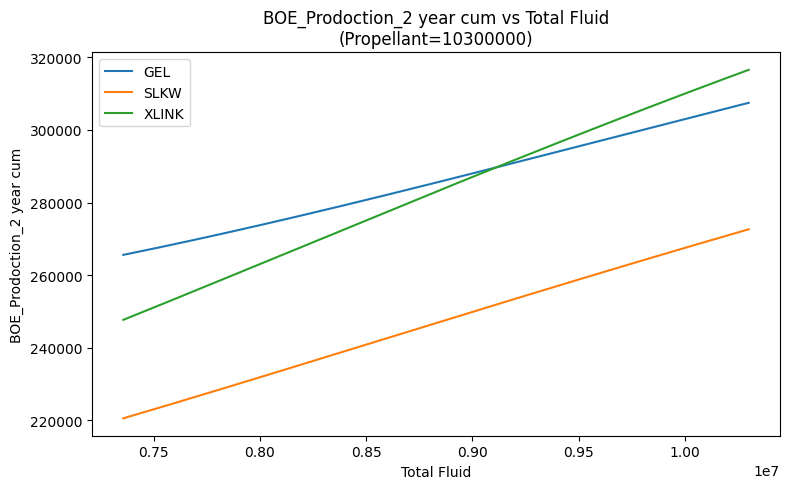

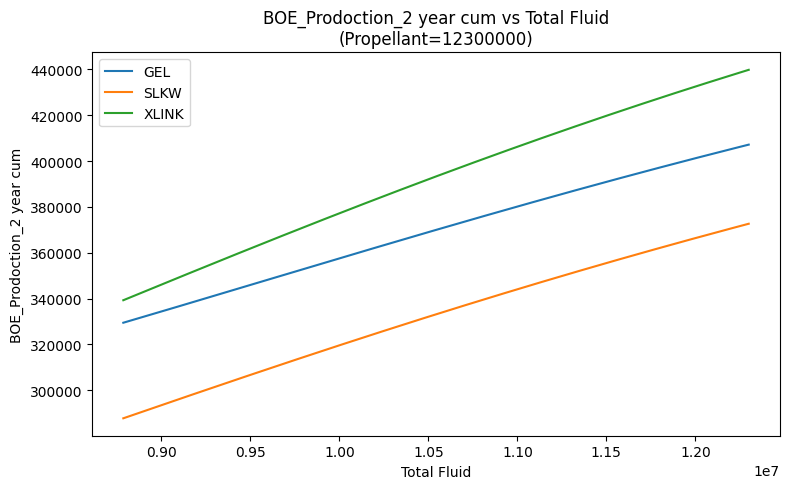

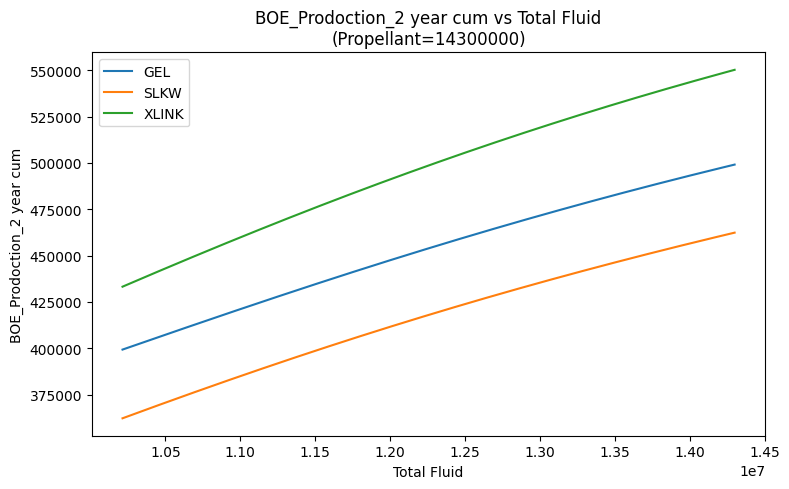

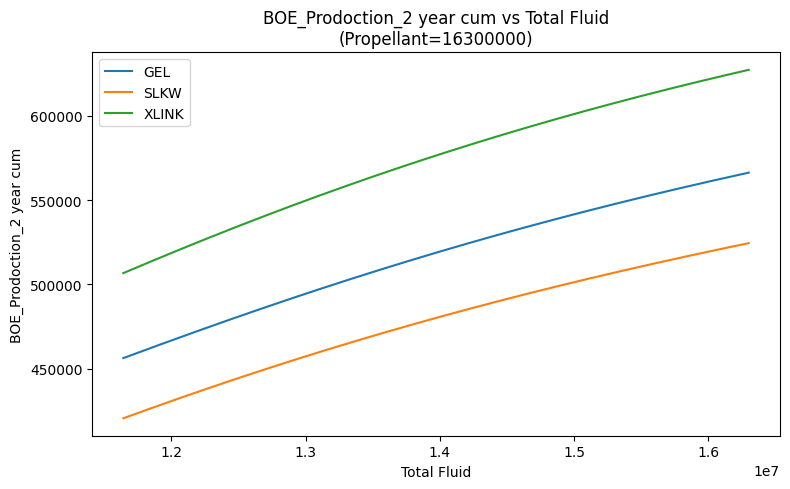

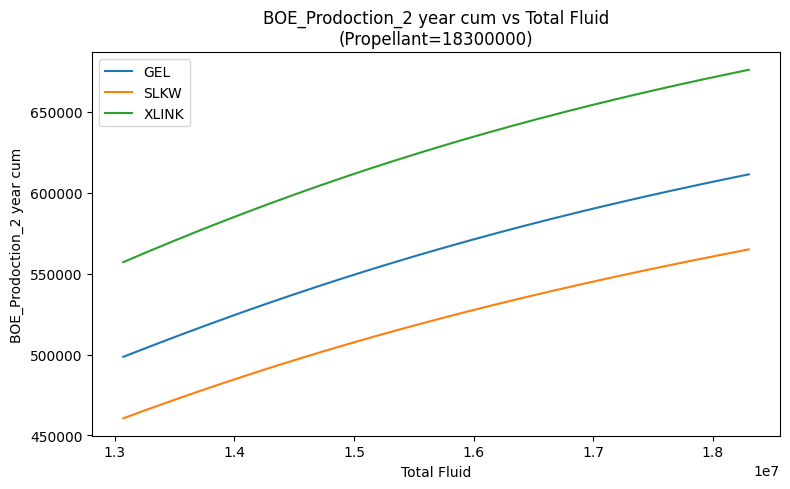

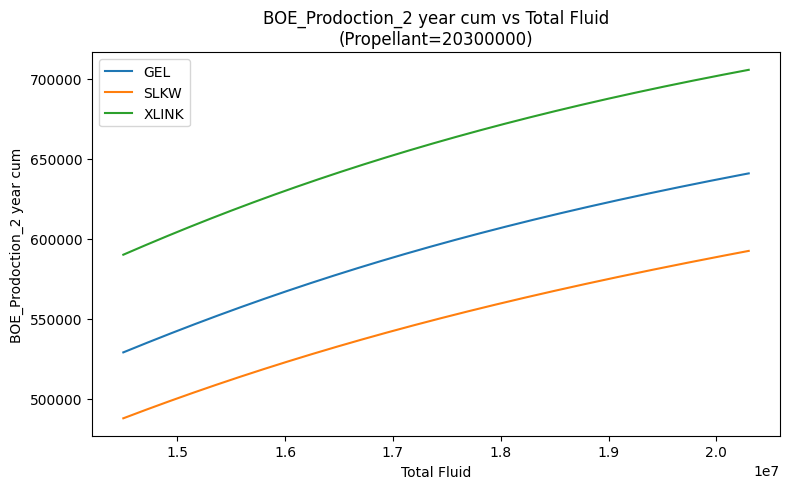

In [4]:
# ─── Full example call ──────────────────────────────────────────────────────
plot_sensitivity_auto_fluid(
    run_folder="/home/kamiar/chevron/Eagle-Ford/Second/4eb5e823",
    fold=1,
    test_csv="/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_test.csv",
    include_ratio_features = True,
    sample_index=sample_index,
    total_propellant_vals = total_propellant_vals,
    fluid_ratio_min= fluid_ratio_min,
    fluid_ratio_max = fluid_ratio_max,
    num_fluid_points = num_fluid_points,
)


# relu rdundatn reemoved

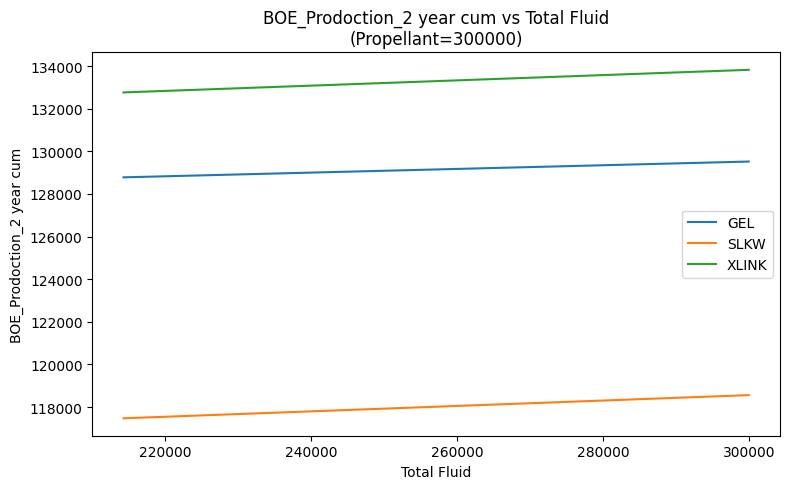

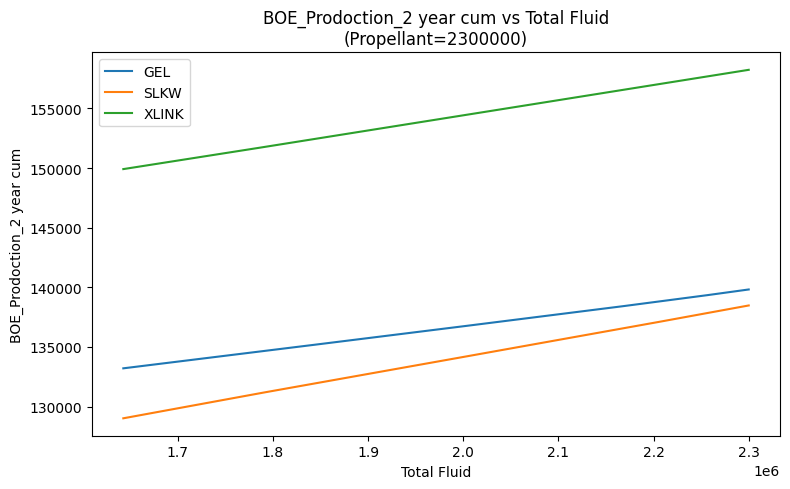

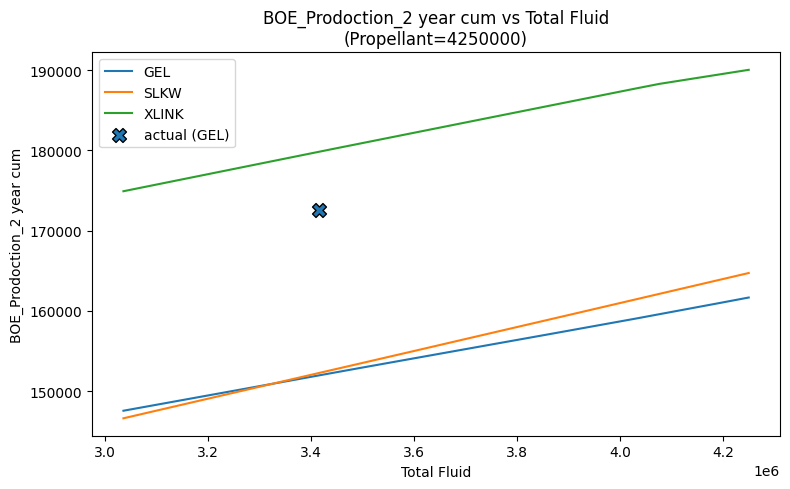

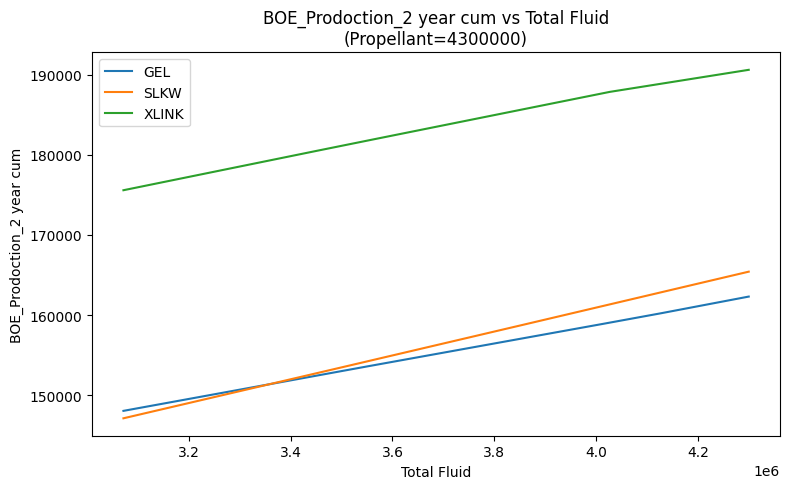

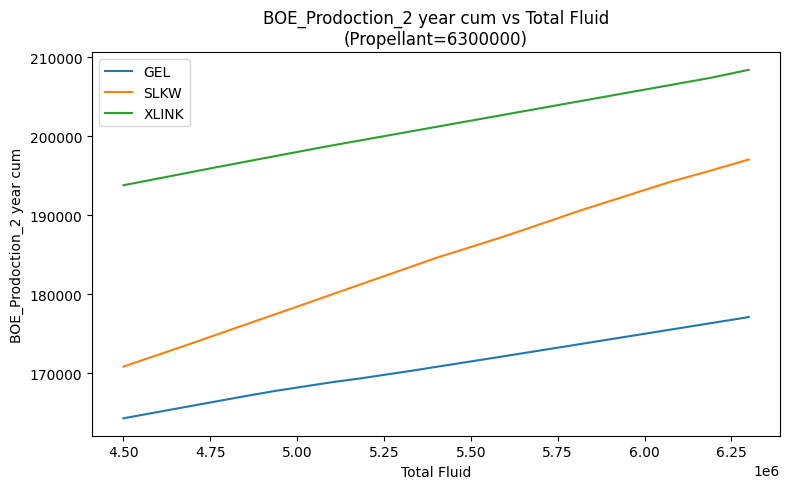

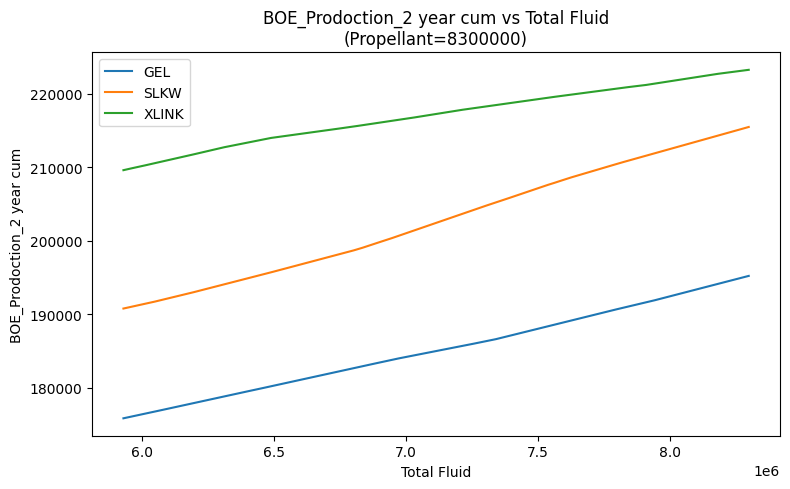

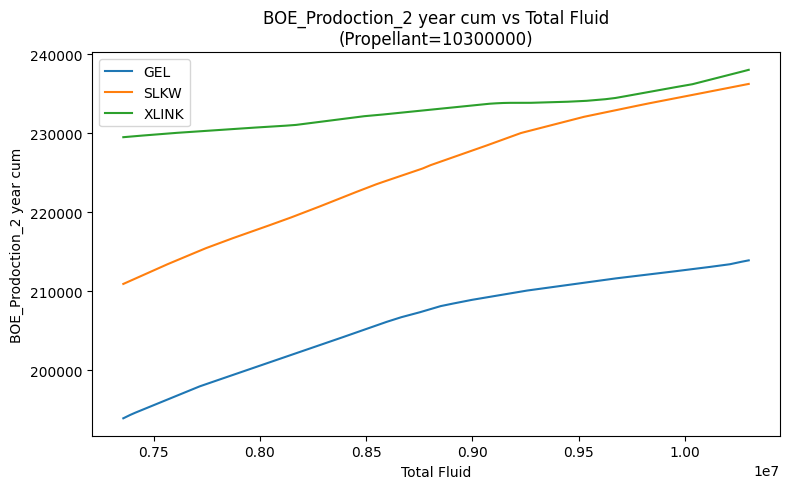

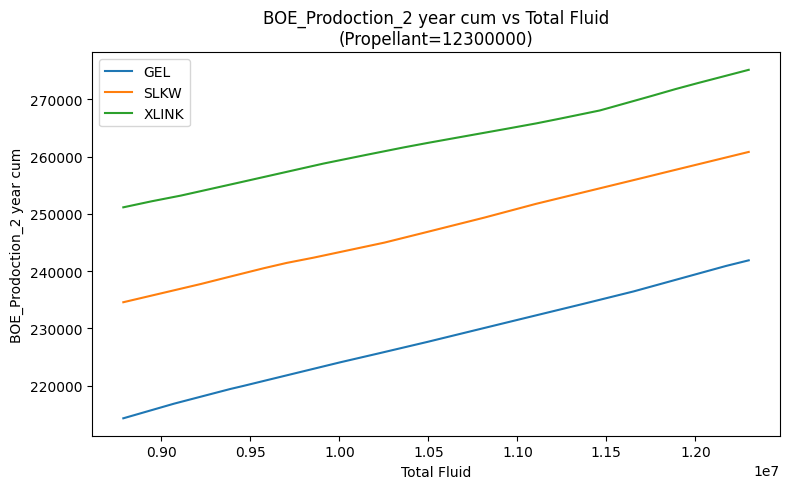

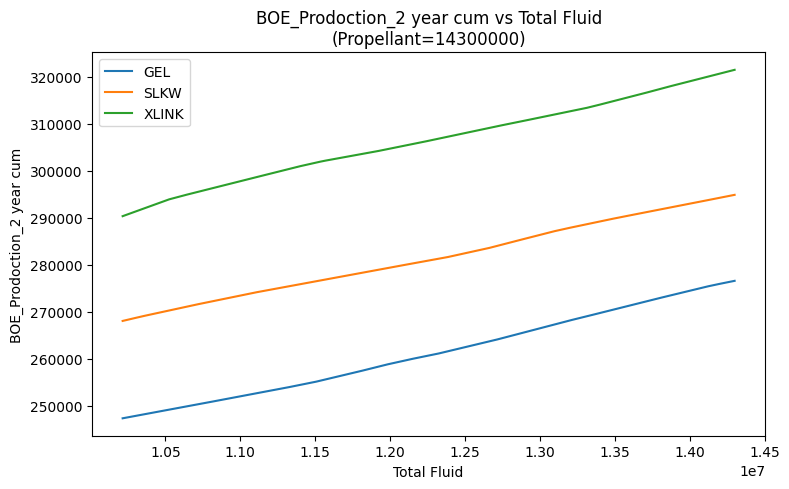

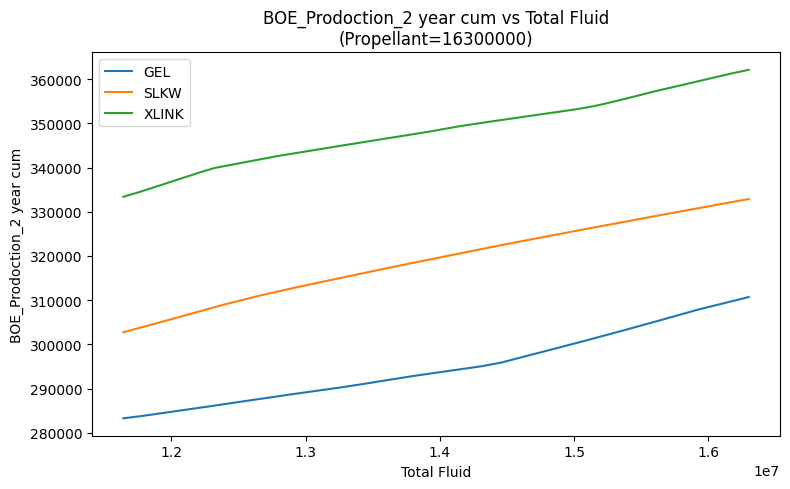

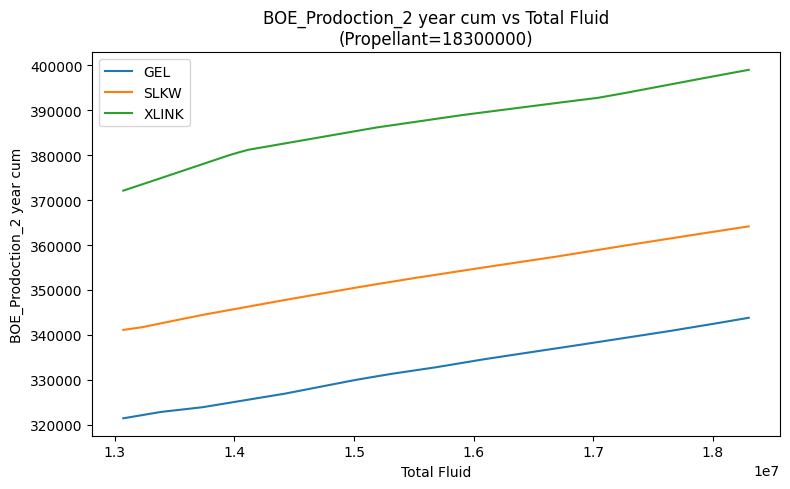

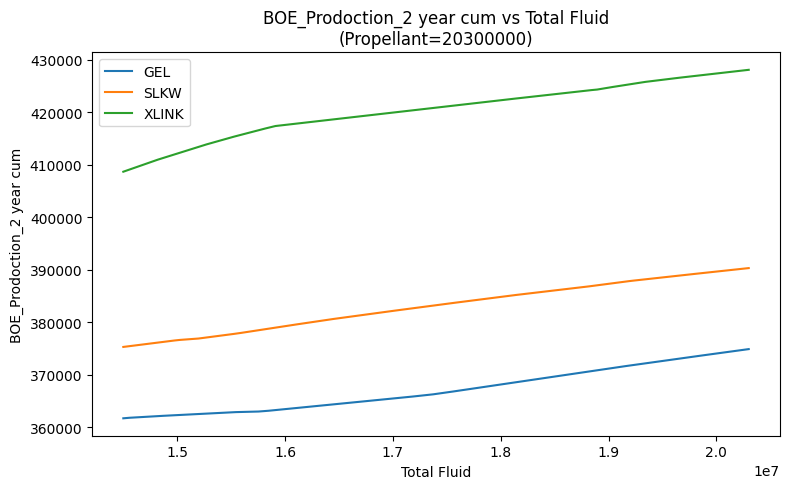

In [5]:
# ─── Full example call ──────────────────────────────────────────────────────
plot_sensitivity_auto_fluid(
    run_folder="/home/kamiar/chevron/Eagle-Ford/Second/5044f3a3",
    fold=6,
    test_csv="/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_test.csv",
    include_ratio_features = False,
    sample_index=sample_index,
    total_propellant_vals = total_propellant_vals,
    fluid_ratio_min= fluid_ratio_min,
    fluid_ratio_max = fluid_ratio_max,
    num_fluid_points = num_fluid_points,
)


# redundatn removed softplus

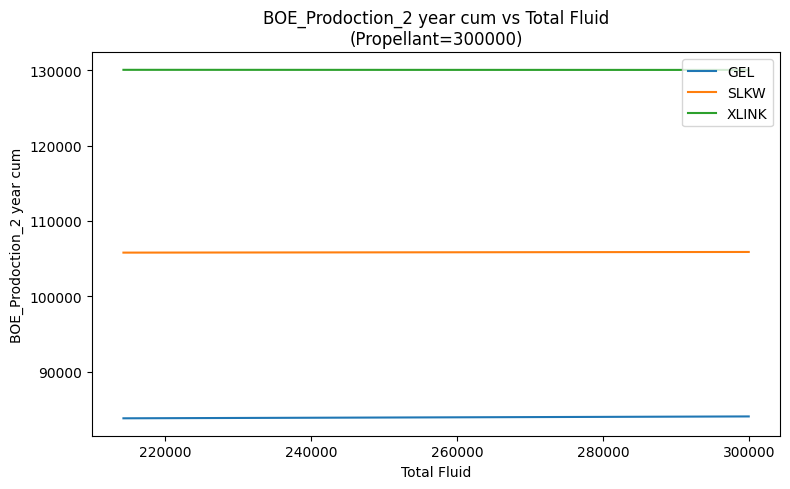

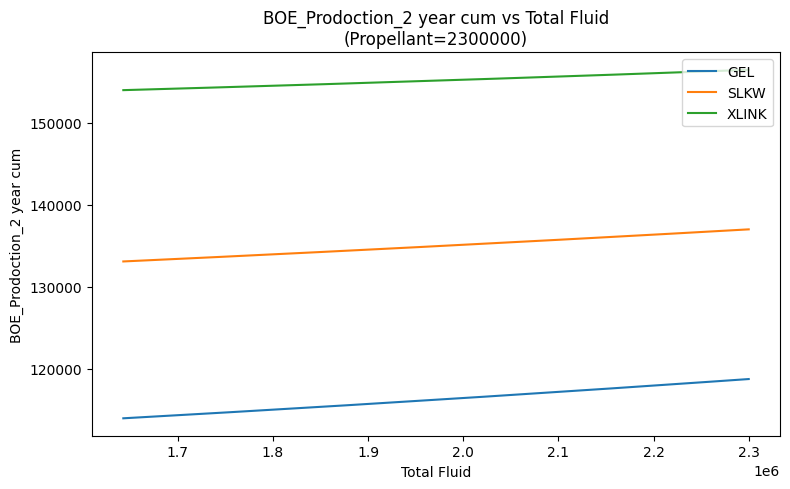

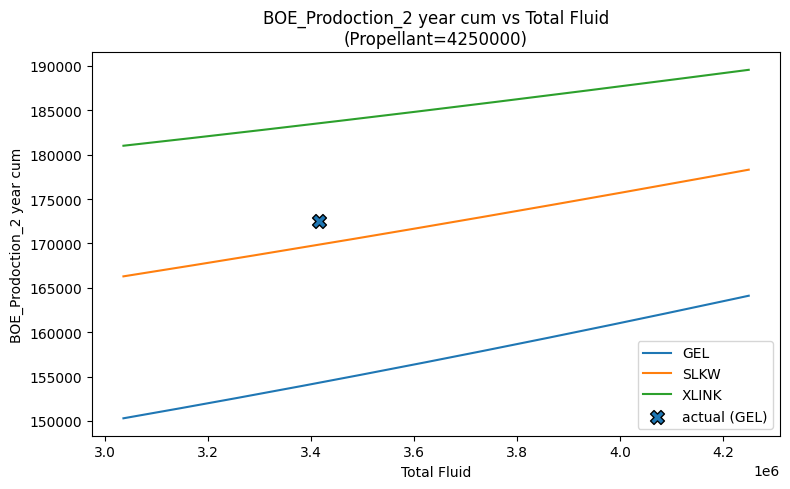

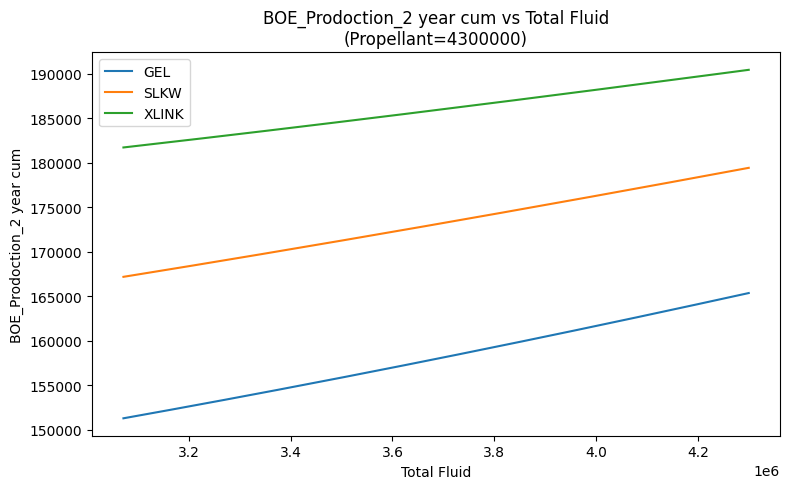

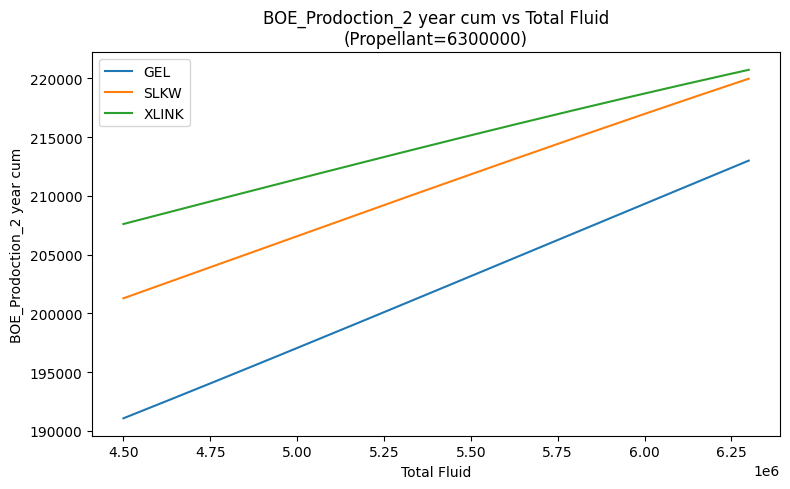

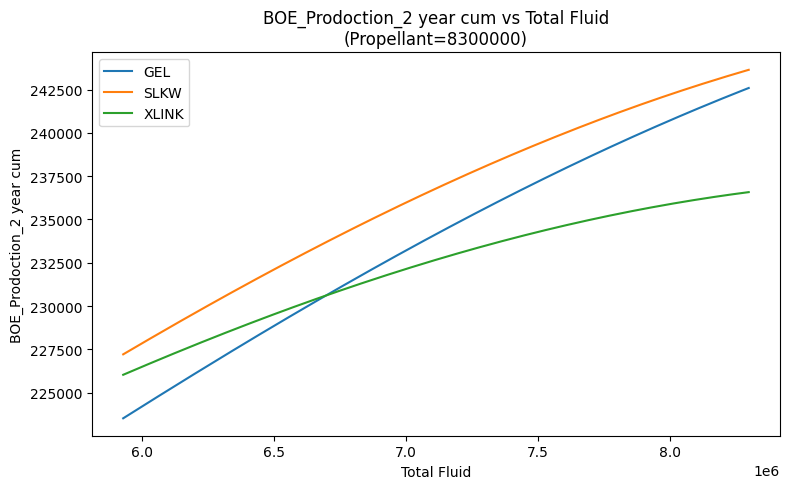

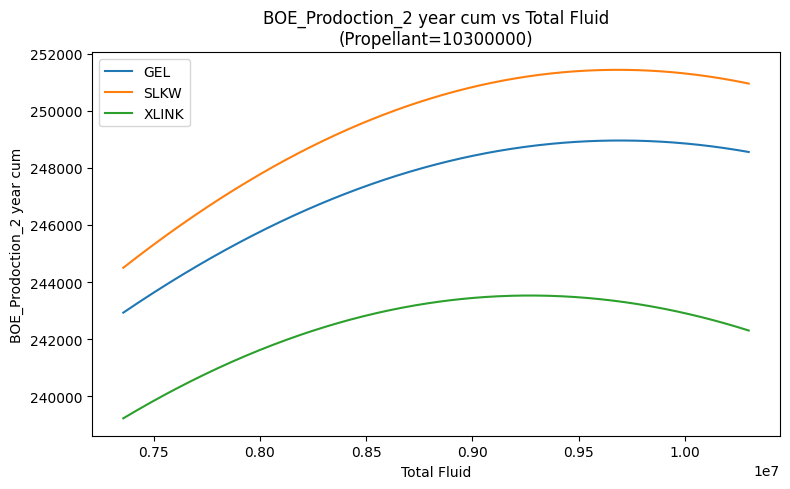

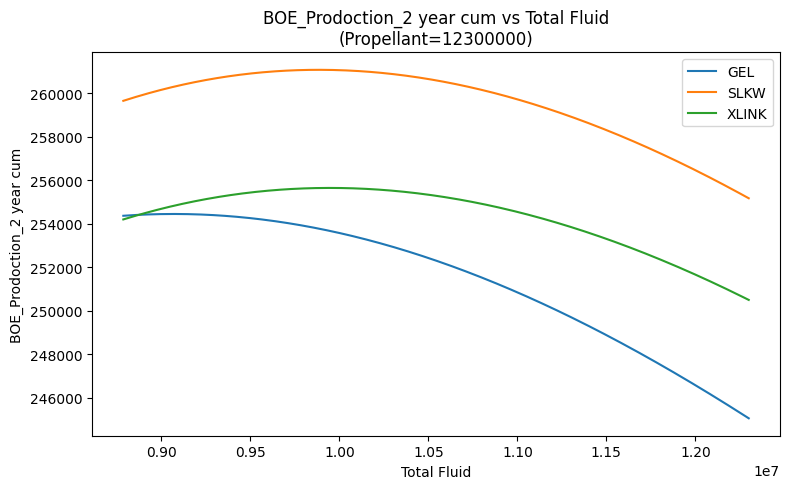

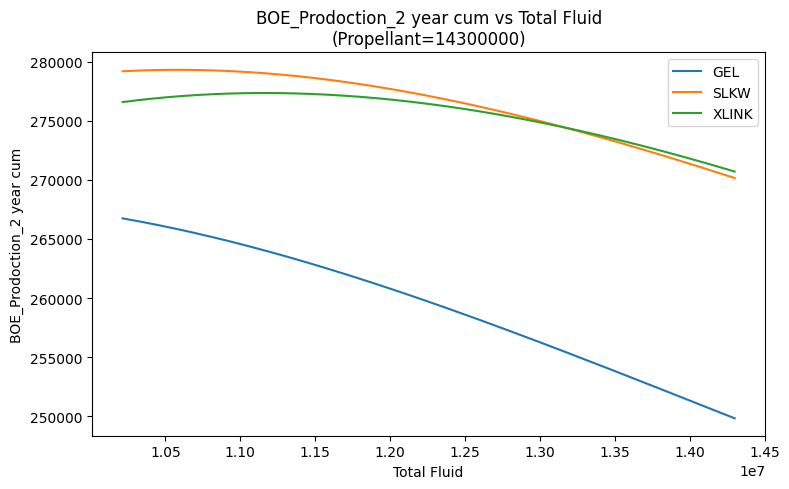

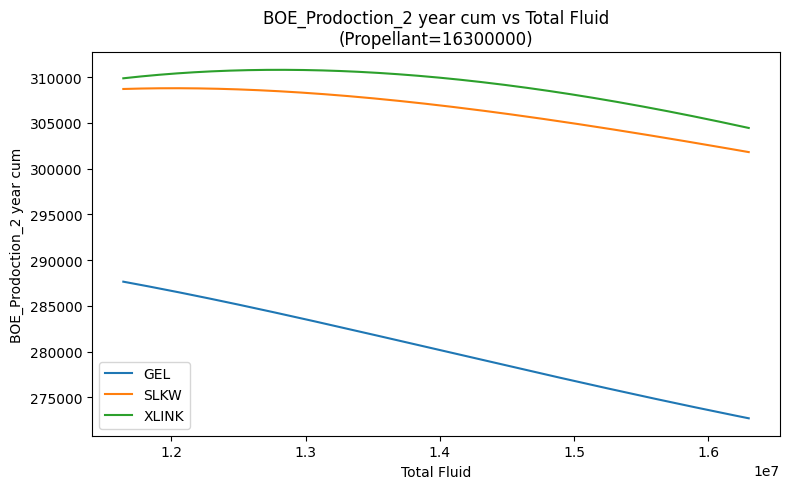

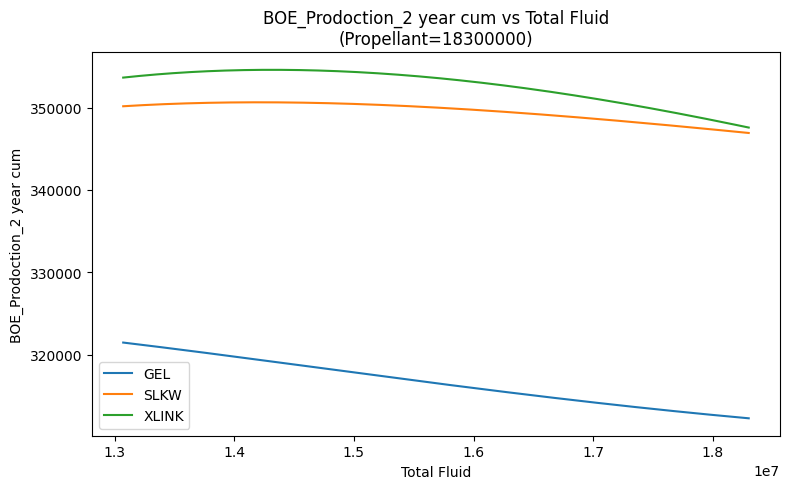

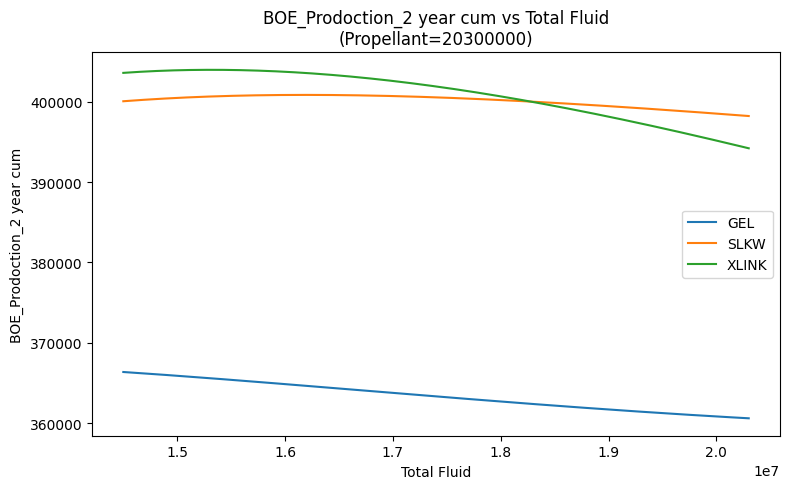

In [6]:
# ─── Full example call ──────────────────────────────────────────────────────
plot_sensitivity_auto_fluid(
    run_folder="/home/kamiar/chevron/Eagle-Ford/Second/98a1fcb5",
    fold=6,
    test_csv="/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_test.csv",
    include_ratio_features = False,
    sample_index=sample_index,
    total_propellant_vals = total_propellant_vals,
    fluid_ratio_min= fluid_ratio_min,
    fluid_ratio_max = fluid_ratio_max,
    num_fluid_points = num_fluid_points,
)
